## Load model

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Reshape, Lambda, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

def CNN_model(input_shape = (64, 64, 3), is_training = True):
        model = Sequential()
        model.add(Lambda( lambda x : x / 127.5 - 1., input_shape= input_shape))
        model.add(Conv2D(64, (5, 5), activation="relu", padding = "same"))
        model.add(MaxPooling2D(pool_size = (2,2)))

        model.add(Conv2D(128, (3, 3), padding = "same", activation="relu"))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Conv2D(128, (3, 3), padding = "same", activation="relu"))
        model.add(MaxPooling2D(pool_size = (2,2)))  
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        #this layer acts like a dense layer with 128 units but we keep it fully convolutional
        model.add(Conv2D(64, (8,8), activation = "relu"))
        model.add(Dropout(0.2))   
    
        model.add(Conv2D(2, (1,1)))
        model.add(Activation(K.softmax))
    
        if is_training:
            model.add(Reshape( (2,) ))
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
        return model
    
model = CNN_model(input_shape = (260, 1280, 3), is_training = False)
model.load_weights('./model/model.h5')

Using TensorFlow backend.


## Test Model

In [2]:
import glob
import os
import time
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
from scipy.misc import imresize
import numpy as np
def gen_heatmap(img, class_index):
    global model
    img_crop = img[400:660,:,:]
    img_crop = imresize(img_crop,(260, 1280))
    img_crop = np.expand_dims(img_crop, axis = 0)
    heatmap = model.predict(img_crop)
    print(heatmap.shape)
    heatmap[ heatmap < 0.99 ] = 0
    heatmap[ heatmap >= 0.99] = 1
    heatmap2 = np.squeeze(heatmap)[:, :, class_index]
    return heatmap2

In [33]:
import cv2

def get_bboxes(heatmap):
    xx, yy = np.meshgrid(np.arange(heatmap.shape[1]),np.arange(heatmap.shape[0]))
    x = (xx[heatmap == 1])   #get 
    y = (yy[heatmap == 1])
    boxpts = []
    for i,j in zip(x,y):
        topleft = [i*8, j*8 + 400]
        topright = [i*8 + 64, j*8 + 400]
        botright = [i*8 + 64, j*8 + 464]
        botleft = [i*8, j*8 + 464]
        boxpts.append( np.array([topleft, topright, botright, botleft])  )  
    return boxpts

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]: box[2][1], box[0][0]:box[2][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

(1, 25, 153, 2)


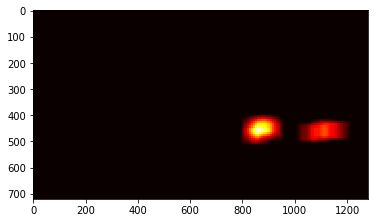

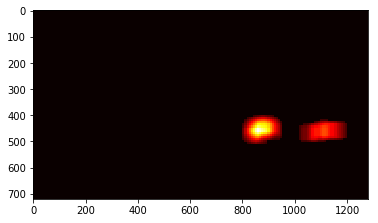

2 cars found


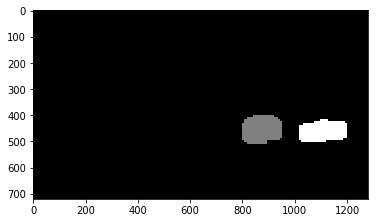

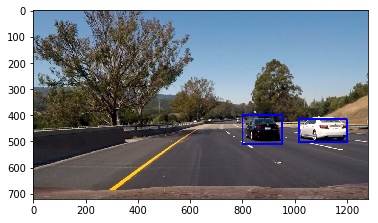

In [45]:
img = mpimg.imread('./test_images/test6.jpg')
heatmap = gen_heatmap(img, 1)
bboxs =  get_bboxes(heatmap)

heat = np.zeros(img.shape[0:2], dtype = np.float)

heat = add_heat(heat, bboxs)
plt.imshow(heat, cmap='hot')
plt.show()
heat = apply_threshold(heat, 3)
plt.imshow(heat, cmap='hot')
plt.show()

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
from scipy.ndimage.measurements import label
labels = label(heat)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

draw_img = draw_labeled_bboxes(np.copy(img), labels)
plt.imshow(draw_img)
plt.show()

(1, 25, 153, 2)
2 cars found


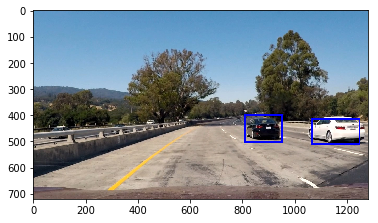

(1, 25, 153, 2)
0 cars found


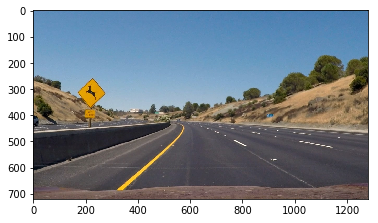

(1, 25, 153, 2)
1 cars found


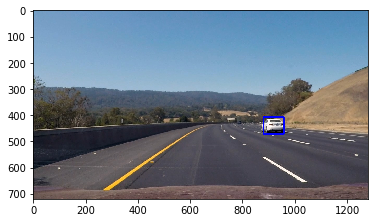

(1, 25, 153, 2)
2 cars found


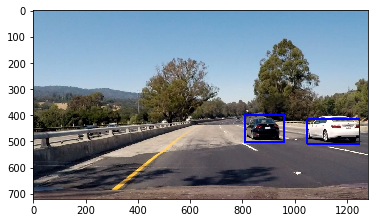

(1, 25, 153, 2)
2 cars found


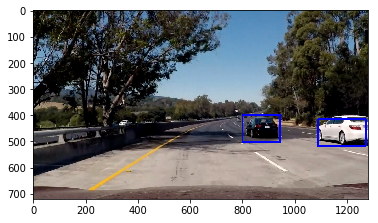

(1, 25, 153, 2)
2 cars found


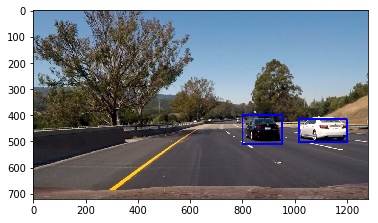

In [53]:
img_paths = glob.glob('./test_images/*.jpg')
save_path = './output_images'
from scipy.ndimage.measurements import label
for img_path in img_paths:
    img_name = os.path.split(img_path)[-1]
    img = mpimg.imread(img_path)
    heatmap = gen_heatmap(img, 1)
    bboxs =  get_bboxes(heatmap)

    heat = np.zeros(img.shape[0:2], dtype = np.float)

    heat = add_heat(heat, bboxs)
    #plt.imshow(heat, cmap='hot')
    #plt.show()
    heat = apply_threshold(heat, 3)
    #plt.imshow(heat, cmap='hot')
    #plt.show()

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    labels = label(heat)
    print(labels[1], 'cars found')
    #plt.imshow(labels[0], cmap='gray')
    #plt.show()

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.imshow(draw_img)
    plt.show()
    #mpimg.imsave(save_path + '/result_'+img_name, draw_img, format='png')

In [54]:
def pipline(img):
    global model
    img_crop = img[400:660,:,:]
    img_crop = imresize(img_crop,(260, 1280))
    img_crop = np.expand_dims(img_crop, axis = 0)
    heatmap = model.predict(img_crop)
    heatmap[ heatmap < 0.99 ] = 0
    heatmap[ heatmap >= 0.99] = 1
    heatmap2 = np.squeeze(heatmap)[:, :, 1]    
    bboxes = get_bboxes(heatmap2)
    
    heat = np.zeros(img.shape[0:2], dtype = np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)
    labels = label(heat)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [55]:
from moviepy.editor import VideoFileClip
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

lane_clip = clip1.fl_image(pipline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:38<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 3min 39s


In [10]:
from moviepy.editor import VideoFileClip
project_video_output = './test_video_output.mp4'
clip2 = VideoFileClip("./test_video.mp4")

lane_clip = clip2.fl_image(pipline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:12<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 

Wall time: 15.2 s
